In [14]:
import numpy as np
import pandas as pd
import re
import pickle
import gc

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# LightGBM
# !pip install lightgbm==3.2.1  #LightGBMバージョン指定（書籍の再現性のため）
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [15]:
application_train = pd.read_csv("../../input/home-credit-default-risk/application_train.csv")
print(application_train.shape)
application_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


ファイル数が多く、各ファイルのサイズも大きいので、処理の途中でメモリ不足になるかもしれない

これを防ぐために各カラムのデータに応じて、データ型を最適化する必要がある

以下がその関数


In [16]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [17]:
application_train = reduce_mem_usage(application_train)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


286.23MB -> 92.38MB

67.7％削減

## ベースライン

### データセットの作成


In [18]:
x_train = application_train.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = application_train["TARGET"]
id_train = application_train[["SK_ID_CURR"]]

In [19]:
# カテゴリ変数をcategory型に変換
for col in x_train.columns:
    if x_train[col].dtype == "object":
        x_train[col] = x_train[col].astype("category")


### バリデーション設計(クロスバリデーション)

In [20]:
# 目的変数における、１の割合とそれぞれの件数
print(f'mean: {y_train.mean():.4f}')
y_train.value_counts()

mean: 0.0807


TARGET
0    282686
1     24825
Name: count, dtype: int64

1の割合: 8%

-> 不均衡データ

In [21]:
# １の割合を8％の状態でちゃんと分割したい！
# StratifiedKFoldを使うことで、自動的に、foldごとの１の割合が均等になるように分割
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(x_train, y_train))

# インデックス番号が正しく層化されているか、バランス良く分割されているかを確認
print('fold=0の学習データ: ', cv[0][0])
print('fold=0のテストデータ: ', cv[0][1])


fold=0の学習データ:  [     0      1      2 ... 307507 307508 307509]
fold=0のテストデータ:  [     3      6     30 ... 307492 307500 307510]


### モデル作成し、foldごとに処理をする
1. 学習データと検証データに分離
2. モデル学習
3. モデル評価
4. OOFデータの推論値取得
5. 説明変数の重要度取得


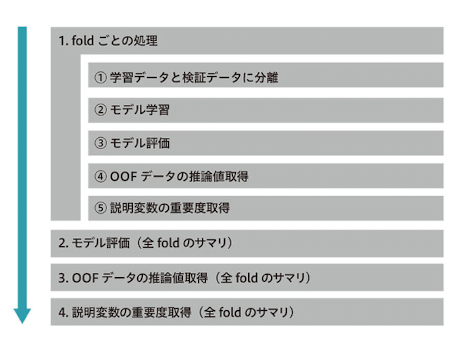

In [22]:
from IPython.display import Image, display
display(Image(filename="../../working/Home_Credit_Default_Risk/modle_learning.png"))

#### 1.学習データと検証データに分離

In [23]:
# foldごとのindexのリスト作成
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train, y_train))

# 0fold目のindexのリスト取得
nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

# 学習データと検証データに分離
x_tr, y_tr, id_tr = x_train.loc[idx_tr, :], y_train[idx_tr], id_train.loc[idx_tr, :]
x_va, y_va, id_va = x_train.loc[idx_va, :], y_train[idx_va], id_train.loc[idx_va, :]
print(x_tr.shape, y_tr.shape, id_tr.shape)
print(x_va.shape, y_va.shape, id_va.shape)

(246008, 120) (246008,) (246008, 1)
(61503, 120) (61503,) (61503, 1)


#### 2. モデル学習

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

# モデルの学習
model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr,y_tr), (x_va,y_va)],
          callbacks=[
              lgb.early_stopping(stopping_rounds=100, verbose=True),
              lgb.log_evaluation(100),
          ],
         )

# モデルの保存
with open("model_lgb_fold0.pickle", "wb") as f:
    pickle.dump(model, f, protocol=4)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11367
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.782506	valid_1's auc: 0.755903
[200]	training's auc: 0.808961	valid_1's auc: 0.758356
[300]	training's auc: 0.829245	valid_1's auc: 0.757774
Early stopping, best iteration is:
[217]	training's auc: 0.812578	valid_1's auc: 0.758595


#### 3. モデル評価

In [25]:
# モデルの評価
# 学習データの推論値取得とROC計算
y_tr_pred = model.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, y_tr_pred)

# 検証データの推論値取得とROC計算
y_va_pred = model.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

# 評価値を入れる変数の作成（最初のfoldのときのみ）
metrics = []

# 評価値を格納
metrics.append([nfold, metric_tr, metric_va])

# 結果の表示
print(f"[auc] tr:{metric_tr:.4f}, va:{metric_va:.4f}")

[auc] tr:0.8126, va:0.7586


#### 4. OOFデータの推論値取得
OOF(Out-of-Fold): 学習データのうち、学習に使わなかったデータ

In [26]:
# oofの予測値を入れる変数の作成(０で初期化)
train_oof = np.zeros(len(x_train))

# validデータのindexに予測値を格納
train_oof[idx_va] = y_va_pred

#### 5.説明変数の重要度取得

In [27]:
# 説明変数の重要度取得
imp_fold = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_, "nfold":nfold})
# 確認（重要度の上位10個）
display(imp_fold.sort_values("imp", ascending=False)[:10])

# 重要度を格納する5fold用データフレームの作成
imp = pd.DataFrame()
# imp_foldを5fold用データフレームに結合
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
41,EXT_SOURCE_3,66225.020483,0
40,EXT_SOURCE_2,52568.833805,0
38,ORGANIZATION_TYPE,20218.523523,0
39,EXT_SOURCE_1,19776.252288,0
6,AMT_CREDIT,8111.321247,0
8,AMT_GOODS_PRICE,7120.960365,0
15,DAYS_BIRTH,7042.223005,0
7,AMT_ANNUITY,6992.551795,0
16,DAYS_EMPLOYED,5236.514120,0
26,OCCUPATION_TYPE,4376.651746,0


### モデルの評価(Fold全体)

In [28]:
# リスト型をarray型に変換
metrics = np.array(metrics)
print(metrics)

# 学習/検証データの評価値の平均値と標準偏差を算出
print("[cv] tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

# oofの評価値を算出
print("[oof] {:.4f}".format(
    roc_auc_score(y_train, train_oof)
))

[[0.         0.81257796 0.75859528]]
[cv] tr:0.8126+-0.0000, va:0.7586+-0.0000
[oof] 0.5103


### OOFデータの推論値取得（Fold全体）

In [29]:
train_oof = pd.concat([
    id_train,
    pd.DataFrame({"true": y_train, "pred": train_oof}),
], axis=1)
train_oof.head()

,SK_ID_CURR,true,pred
0,100002,1,0.000000
1,100003,0,0.000000
2,100004,0,0.031866
3,100006,0,0.000000
4,100007,0,0.000000


### 説明変数の重要度（Fold全体）

In [30]:
# 標準偏差により、モデルにおける重要度のバラツキを確認
imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
imp.columns = ["col", "imp", "imp_std"]
imp.head()

,col,imp,imp_std
0,AMT_ANNUITY,6992.551795,NaN
1,AMT_CREDIT,8111.321247,NaN
2,AMT_GOODS_PRICE,7120.960365,NaN
3,AMT_INCOME_TOTAL,1595.740609,NaN
4,AMT_REQ_CREDIT_BUREAU_DAY,128.842901,NaN


まだfoldを一度しか実行していないので、標準偏差の差は「NaN」になっている

これまでの工程を関数化！

In [31]:
def train_lgb(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
             ):
    train_oof = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()

    # cross-validation
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        
        # make dataset
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr, id_tr = input_x.loc[idx_tr, :], input_y[idx_tr], input_id.loc[idx_tr, :]
        x_va, y_va, id_va = input_x.loc[idx_va, :], input_y[idx_va], input_id.loc[idx_va, :]
        print(x_tr.shape, x_va.shape)
        
        # train
        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=100, verbose=True),
                      lgb.log_evaluation(100),
                  ],
                 )
        
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "wb") as f:
            pickle.dump(model, f, protocol=4)
        
        # evaluate
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({"col":input_x.columns, "imp":model.feature_importances_, "nfold":nfold})
        imp = pd.concat([imp, _imp])
      
    print("-"*20, "result", "-"*20)
    # metric
    metrics = np.array(metrics)
    print(metrics)
    print("[cv] tr:{:.4f}+-{:.4f}, va:{:.4f}+-{:.4f}".format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std(),
    ))
    print("[oof] {:.4f}".format(
        roc_auc_score(input_y, train_oof)
    ))
    
    # oof
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({"pred":train_oof})
    ], axis=1)
    
    # importance
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
    imp.columns = ["col", "imp", "imp_std"]
    
    return train_oof, imp, metrics

5つのFoldに対し、再度学習！

In [32]:
# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

# 学習の実行
train_oof, imp, metrics = train_lgb(x_train,
                                    y_train,
                                    id_train,
                                    params,
                                    list_nfold=[0,1,2,3,4],
                                    n_splits=5,
                                   )

-------------------- 0 --------------------
(246008, 120) (61503, 120)
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11367
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.782506	valid_1's auc: 0.755903
[200]	training's auc: 0.808961	valid_1's auc: 0.758356
[300]	training's auc: 0.829245	valid_1's auc: 0.757774
Early stopping, best iteration is:
[217]	training's auc: 0.812578	valid_1's auc: 0.758595
[auc] tr:0.8126, va:0.7586
-------------------- 1 

In [33]:
# 説明変数の重要度の確認
imp.sort_values('imp', ascending=False)[:10]

,col,imp,imp_std
38,EXT_SOURCE_3,65353.907478,1558.201212
37,EXT_SOURCE_2,54545.388309,1251.798934
102,ORGANIZATION_TYPE,21441.917474,1450.246190
36,EXT_SOURCE_1,20051.934248,685.852224
1,AMT_CREDIT,8263.228728,410.384434
22,DAYS_BIRTH,7645.589110,689.458833
2,AMT_GOODS_PRICE,7263.054566,405.837031
0,AMT_ANNUITY,6762.953640,479.302045
23,DAYS_EMPLOYED,5810.288375,552.937730
101,OCCUPATION_TYPE,5502.675859,831.872392


### モデル推論

In [35]:
application_test = pd.read_csv("../../input/home-credit-default-risk/application_test.csv")
application_test = reduce_mem_usage(application_test)

# データセットの作成
x_test = application_test.drop(columns=["SK_ID_CURR"])
id_test = application_test[["SK_ID_CURR"]]

# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


In [36]:
### foldごと
# 1. 学習モデルの読み込み
with open("model_lgb_fold0.pickle", "rb") as f:
    model = pickle.load(f)

# 2. 推論
# 推論
test_pred_fold = model.predict_proba(x_test)[:,1]

# 推論値を格納する変数を作成
test_pred = np.zeros((len(x_test), 5))

# 1fold目の予測値を格納
test_pred[:, 0] = test_pred_fold


### 全foldのサマリ
# 各foldの推論値の平均値を算出
test_pred_mean = test_pred.mean(axis=1)

# 推論値のデータフレームを作成
df_test_pred = pd.concat([
        id_test,
        pd.DataFrame({"pred": test_pred_mean}),
    ], axis=1)
df_test_pred.head()

,SK_ID_CURR,pred
0,100001,0.006572
1,100005,0.023874
2,100013,0.004233
3,100028,0.008966
4,100038,0.030794


In [37]:
# 関数化
def predict_lgb(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print("-"*20, nfold, "-"*20)
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "rb") as f:
            model = pickle.load(f)
        pred[:, nfold] = model.predict_proba(input_x)[:,1]
    
    pred = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis=1)}),
    ], axis=1)
    
    print("Done.")
    
    return pred

In [38]:
# 推論処理の実行
test_pred = predict_lgb(x_test,
                        id_test,
                        list_nfold=[0,1,2,3,4],
                       )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [39]:
test_pred.head()

,SK_ID_CURR,pred
0,100001,0.041810
1,100005,0.126400
2,100013,0.022495
3,100028,0.039680
4,100038,0.156628


In [40]:
df_submit = test_pred.rename(columns={"pred":"TARGET"})
print(df_submit.shape)
display(df_submit.head())

df_submit.to_csv("submission_baseline.csv", index=None)

(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.041810
1,100005,0.126400
2,100013,0.022495
3,100028,0.039680
4,100038,0.156628


## 特徴量エンジニアリング

In [41]:
display(application_train["DAYS_EMPLOYED"].value_counts())
print("正の値の割合: {:.4f}".format((application_train["DAYS_EMPLOYED"]>0).mean()))
print("正の値の個数: {}".format((application_train["DAYS_EMPLOYED"]>0).sum()))
# -> 正の値が18%。しかもすべて8割が365243と同一値。働き始めてからの日数をマイナス表記しているためこれは欠損と判断。

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: count, Length: 12574, dtype: int64

正の値の割合: 0.1801
正の値の個数: 55374


In [42]:
application_train["DAYS_EMPLOYED"] = application_train["DAYS_EMPLOYED"].replace(365243, np.nan)

##### 仮説
- 【仮説 1】所持金が同じでも、家族人数が多い方が経済的な負担が大きいので貸し倒れしやすそう

    　⇒【特徴量】総所得金額を世帯人数で割った値（家族一人あたりの総所得）

- 【仮説 2】所得金額が同じでも、就労期間が短い方が優秀で貸し倒れしにくそう

    　⇒【特徴量 2】総所得金額を就労期間で割った値

- 【仮説 3】外部機関によるスコア（EXT_SOURCE_1〜3）が平均的に高い方が貸し倒れしにくそう

    　⇒【特徴量 3】外部スコアの平均値（そのほかにも最大値・最小値なども追加）

- 【仮説 4】年齢に占める就労期間が長い方が貸し倒れしにくそう（離職可能性が低く支払い不能状態になりにくそう）

    　⇒【特徴量 4】就労期間を年齢で割った値

- 【仮説 5】所得金額に占める年金支払額が少ない方が貸し倒れしにくそう

    　⇒【特徴量 5】年金支払額を所得金額で割った値

- 【仮説 6】借入金に占める年金支払額が少ない方が貸し倒れしにくそう

    　⇒【特徴量 6】年金支払額を借入金で割った値


In [43]:
# 特徴量1: 総所得金額を世帯人数で割った値
application_train['INCOME_div_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']

# 特徴量2: 総所得金額を就労期間で割った値
application_train['INCOME_div_EMPLOYED'] = application_train['AMT_INCOME_TOTAL'] / application_train['DAYS_EMPLOYED']

# 特徴量3: 外部スコアの平均値など
application_train["EXT_SOURCE_mean"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
application_train["EXT_SOURCE_max"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
application_train["EXT_SOURCE_min"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
application_train["EXT_SOURCE_std"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
application_train["EXT_SOURCE_count"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)

# 特徴量4: 就労期間を年齢で割った値 (年齢に占める就労期間の割合)
application_train['DAYS_EMPLOYED_div_BIRTH'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']

# 特徴量5: 年金支払額を所得金額で割った値
application_train['ANNUITY_div_INCOME'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']

# 特徴量6: 年金支払額を借入金で割った値
application_train['ANNUITY_div_CREDIT'] = application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']

In [44]:
# 上記で作成した特徴量で再度学習
# データセット作成
x_train = application_train.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = application_train["TARGET"]
id_train = application_train[["SK_ID_CURR"]]

for col in x_train.columns:
    if x_train[col].dtype=="O":
        x_train[col] = x_train[col].astype("category")

# モデル学習
train_oof, imp, metrics = train_lgb(x_train,
                                    y_train,
                                    id_train,
                                    params,
                                    list_nfold=[0,1,2,3,4],
                                    n_splits=5,
                                   )

-------------------- 0 --------------------
(246008, 130) (61503, 130)
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13680
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.787817	valid_1's auc: 0.760032
[200]	training's auc: 0.816788	valid_1's auc: 0.763696
[300]	training's auc: 0.838351	valid_1's auc: 0.764008
[400]	training's auc: 0.856611	valid_1's auc: 0.764045
[500]	training's auc: 0.871304	valid_1's auc: 0.764075
Early stopping, best iteration

【AUC（CV）のスコアの比較】
- ベースライン：0.7573+-0.0031
- 今：0.7653+-0.0022

上昇している!


In [45]:
# 説明変数の重要度確認
imp.sort_values("imp", ascending=False)[:10]

,col,imp,imp_std
44,EXT_SOURCE_mean,114005.214702,1381.645644
10,ANNUITY_div_CREDIT,23720.301550,805.397477
112,ORGANIZATION_TYPE,22660.210567,1372.230448
41,EXT_SOURCE_3,12046.854638,886.653726
24,DAYS_BIRTH,8108.684084,578.972393
45,EXT_SOURCE_min,7727.391587,314.203161
39,EXT_SOURCE_1,7155.619219,472.422492
2,AMT_GOODS_PRICE,6148.167858,364.159044
0,AMT_ANNUITY,6091.805210,581.987900
46,EXT_SOURCE_std,5830.390690,679.963947


EXT_SOURCE_meanが1位!

ANNUITY_div_INCOMEが2位!

追加した特徴量が上位に来ている

In [46]:
# 推論用データのデータセット作成
# nullに置き換え
application_test["DAYS_EMPLOYED"] = application_test["DAYS_EMPLOYED"].replace(365243, np.nan)

# 特徴量の生成
application_test['INCOME_div_PERSON'] = application_test['AMT_INCOME_TOTAL'] / application_test['CNT_FAM_MEMBERS']
application_test['INCOME_div_EMPLOYED'] = application_test['AMT_INCOME_TOTAL'] / application_test['DAYS_EMPLOYED']
application_test["EXT_SOURCE_mean"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
application_test["EXT_SOURCE_max"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
application_test["EXT_SOURCE_min"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
application_test["EXT_SOURCE_std"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
application_test["EXT_SOURCE_count"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)
application_test['DAYS_EMPLOYED_div_BIRTH'] = application_test['DAYS_EMPLOYED'] / application_test['DAYS_BIRTH']
application_test['ANNUITY_div_INCOME'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']
application_test['ANNUITY_div_CREDIT'] = application_test['AMT_ANNUITY'] / application_test['AMT_CREDIT']

# データセット作成
x_test = application_test.drop(columns=["SK_ID_CURR"])
id_test = application_test[["SK_ID_CURR"]]

# カテゴリ変数をcategory型へ変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")


In [47]:
# 推論処理
test_pred = predict_lgb(x_test,
                        id_test,
                        list_nfold=[0,1,2,3,4],
                       )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [48]:
# 提出ファイル
df_submit = test_pred.rename(columns={"pred":"TARGET"})
print(df_submit.shape)
display(df_submit.head())
df_submit.to_csv("submission_FeatureEngineering1.csv", index=None)

(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.029002
1,100005,0.121782
2,100013,0.022668
3,100028,0.044435
4,100038,0.181940


### POS_CASH_balance.csvを利用した特徴量エンジニアリング

In [49]:
pos = pd.read_csv("../../input/home-credit-default-risk/POS_CASH_balance.csv")
pos = reduce_mem_usage(pos)
print(pos.shape)
pos.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [51]:
# one-hot-encoding(カテゴリ->数値)
pos_ohe = pd.get_dummies(pos, columns=["NAME_CONTRACT_STATUS"], dummy_na=True)
col_ohe = sorted(list(set(pos_ohe.columns) - set(pos.columns)))
print(len(col_ohe))
col_ohe

10


['NAME_CONTRACT_STATUS_Active',
 'NAME_CONTRACT_STATUS_Amortized debt',
 'NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Canceled',
 'NAME_CONTRACT_STATUS_Completed',
 'NAME_CONTRACT_STATUS_Demand',
 'NAME_CONTRACT_STATUS_Returned to the store',
 'NAME_CONTRACT_STATUS_Signed',
 'NAME_CONTRACT_STATUS_XNA',
 'NAME_CONTRACT_STATUS_nan']

In [53]:
# SK_ID_CURRをキーに集約処理
pos_ohe_agg = pos_ohe.groupby("SK_ID_CURR").agg(
    {
        # 数値の集約
        "MONTHS_BALANCE": ["mean", "std", "min", "max"],
        "CNT_INSTALMENT": ["mean", "std", "min", "max"],
        "CNT_INSTALMENT_FUTURE": ["mean", "std", "min", "max"],
        "SK_DPD": ["mean", "std", "min", "max"],
        "SK_DPD_DEF": ["mean", "std", "min", "max"],
        # カテゴリ変数をone-hot-encodingした値の集約
        "NAME_CONTRACT_STATUS_Active": ["mean"],
        "NAME_CONTRACT_STATUS_Amortized debt": ["mean"],
        "NAME_CONTRACT_STATUS_Approved": ["mean"],
        "NAME_CONTRACT_STATUS_Canceled": ["mean"],
        "NAME_CONTRACT_STATUS_Completed": ["mean"],
        "NAME_CONTRACT_STATUS_Demand": ["mean"],
        "NAME_CONTRACT_STATUS_Returned to the store": ["mean"],
        "NAME_CONTRACT_STATUS_Signed": ["mean"],
        "NAME_CONTRACT_STATUS_XNA": ["mean"],
        "NAME_CONTRACT_STATUS_nan": ["mean"],
        # IDのユニーク数をカウント (ついでにレコード数もカウント)
        "SK_ID_PREV":["count", "nunique"],
    }
)

# カラム名の付与
pos_ohe_agg.columns = [i + "_" + j for i,j in pos_ohe_agg.columns]
pos_ohe_agg = pos_ohe_agg.reset_index(drop=False)

print(pos_ohe_agg.shape)
pos_ohe_agg.head()

(337252, 33)


,SK_ID_CURR,MONTHS_BALANCE_mean,MONTHS_BALANCE_std,MONTHS_BALANCE_min,MONTHS_BALANCE_max,CNT_INSTALMENT_mean,CNT_INSTALMENT_std,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_FUTURE_mean,...,NAME_CONTRACT_STATUS_Approved_mean,NAME_CONTRACT_STATUS_Canceled_mean,NAME_CONTRACT_STATUS_Completed_mean,NAME_CONTRACT_STATUS_Demand_mean,NAME_CONTRACT_STATUS_Returned to the store_mean,NAME_CONTRACT_STATUS_Signed_mean,NAME_CONTRACT_STATUS_XNA_mean,NAME_CONTRACT_STATUS_nan_mean,SK_ID_PREV_count,SK_ID_PREV_nunique
0,100001,-72.555556,20.863312,-96,-53,4.000000,0.000000,4.0,4.0,1.444444,...,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9,2
1,100002,-10.000000,5.627314,-19,-1,24.000000,0.000000,24.0,24.0,15.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19,1
2,100003,-43.785714,24.640162,-77,-18,10.107142,2.806597,6.0,12.0,5.785714,...,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28,3
3,100004,-25.500000,1.290994,-27,-24,3.750000,0.500000,3.0,4.0,2.250000,...,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4,1
4,100005,-20.000000,3.316625,-25,-15,11.700000,0.948683,9.0,12.0,7.200000,...,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11,1


In [54]:
# SK_ID_CURRをキーにして結合
df_train = pd.merge(application_train, pos_ohe_agg, on="SK_ID_CURR", how="left")
print(df_train.shape)
df_train.head()

(307511, 164)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NAME_CONTRACT_STATUS_Approved_mean,NAME_CONTRACT_STATUS_Canceled_mean,NAME_CONTRACT_STATUS_Completed_mean,NAME_CONTRACT_STATUS_Demand_mean,NAME_CONTRACT_STATUS_Returned to the store_mean,NAME_CONTRACT_STATUS_Signed_mean,NAME_CONTRACT_STATUS_XNA_mean,NAME_CONTRACT_STATUS_nan_mean,SK_ID_PREV_count,SK_ID_PREV_nunique
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,28.0,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,4.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.095238,0.0,0.047619,0.000000,0.0,0.0,21.0,3.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.045455,0.0,0.000000,0.015152,0.0,0.0,66.0,5.0


上記のデータを使用して学習

In [55]:
# データセット作成
x_train = df_train.drop(columns=["TARGET", "SK_ID_CURR"])
y_train = df_train["TARGET"]
id_train = df_train[["SK_ID_CURR"]]

for col in x_train.columns:
    if x_train[col].dtype=="O":
        x_train[col] = x_train[col].astype("category")

# 学習
train_oof, imp, metrics = train_lgb(x_train,
                                    y_train,
                                    id_train,
                                    params,
                                    list_nfold=[0,1,2,3,4],
                                    n_splits=5,
                                   )

print('-'*20, "説明変数の重要度", '-'*20)
imp.sort_values("imp", ascending=False)[:10]

-------------------- 0 --------------------
(246008, 162) (61503, 162)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18345
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 158
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.79465	valid_1's auc: 0.765484
[200]	training's auc: 0.825851	valid_1's auc: 0.770574
[300]	training's auc: 0.848782	valid

,col,imp,imp_std
52,EXT_SOURCE_mean,112796.343040,1260.011166
134,ORGANIZATION_TYPE,22264.959651,1493.295700
10,ANNUITY_div_CREDIT,18573.626466,465.377905
49,EXT_SOURCE_3,10509.961210,785.287606
53,EXT_SOURCE_min,7268.051164,585.911506
32,DAYS_BIRTH,7168.299166,910.997735
47,EXT_SOURCE_1,6721.761349,482.737576
21,CNT_INSTALMENT_FUTURE_mean,6434.854780,726.421173
108,MONTHS_BALANCE_std,5657.986259,412.262152
0,AMT_ANNUITY,5548.585097,283.031089


推論用データセット

In [56]:
# テーブル結合
df_test = pd.merge(application_test, pos_ohe_agg, on="SK_ID_CURR", how="left")

# データセット作成
x_test = df_test.drop(columns=["SK_ID_CURR"])
id_test = df_test[["SK_ID_CURR"]]

# カテゴリ変数をcategory型へ変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

test_pred = predict_lgb(x_test,
                        id_test,
                        list_nfold=[0,1,2,3,4],
                       )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done.


In [57]:
df_submit = test_pred.rename(columns={"pred":"TARGET"})
print(df_submit.shape)
display(df_submit.head())
df_submit.to_csv("submission_FeatureEngineering2.csv", index=None)

(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.031336
1,100005,0.105986
2,100013,0.027345
3,100028,0.045134
4,100038,0.213013
